Aim: 
- Define best (and second best) stage-damage function for survey dataset to use them as baseline for the multivariat models
- Evaluate functions by MSE, R2 etc

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
#from shapely.geometry import Point, Polygon

from scipy import stats, optimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
df_candidates = pd.read_excel("../input_survey_data/survey_data_candidates_coords.xlsx")


# define as geoDF
df_candidates["geometry"] = gpd.GeoSeries.from_wkt(df_candidates["geometry"])
df_candidates = gpd.GeoDataFrame(df_candidates, crs="EPSG:4326", geometry="geometry")

In [3]:
## remove businesses without direct damage costs

df_candidates.Target_direct_s.value_counts();
df_candidates = df_candidates[df_candidates.Target_direct_s > 0.0]  # 136=0.0
df_candidates = df_candidates[df_candidates.Target_direct_r > 0.0] # 152=0.0

### univariate regressions (linear, square root, expo)


In [4]:
df_candidates = df_candidates[['water_depth_cm', 'inundation_duration_h', 'Target_direct_r', 'Target_direct_s']].dropna()
df_candidates = df_candidates.sort_values(by='water_depth_cm')


y = df_candidates.Target_direct_r.astype("float64")
X = df_candidates['water_depth_cm'].astype("float64")

In [6]:
## linear and root reg without least square method
def linear_func(x,m,c):
    return m*x + c
## Alternative: Linear least squares regression - incluedes already evaluation params
#linear_reg = stats.linregress(X, y)


# Schoppa et al 2020 used square root regression
def root_func(x,m,c):
    return m*np.sqrt(x) + c


def exp_func(x,m,c):
    #p_1st = np.polyfit(X, y, 1)  # linear func, np.log(y) in combi wtih weights
    #m = np.exp(p_1st[1]) # p_1st[1] = slope ? , polynomial back to exponential
    b = -0.5 # initally guessed,  # p_1st[0] 
    return m * np.exp(b * x) + c
#x_fitted = np.linspace(np.min(X), np.max(X), 100) # Create the fitted curve
#y_fitted = m * np.exp(b * x_fitted)  # Create the fitted curve


def standard_deviation(covariance):
    """
    code: https://www.mandeepbasson.com/resources/python/curvefitting/curve_fitting/
    """
    return np.sqrt(np.diag(covariance))


params, pcov = optimize.curve_fit(linear_func, X, y)

def adjusted_r2_score(X, y, y_pred=linear_func(X, *params)):
    """
    # ideas partly from https://www.mandeepbasson.com/resources/python/curvefitting/curve_fitting/
    """
    #y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    try:
        r2_adj = 1 - (1-r2) * (len(y) - 1) / (len(y) - X.shape[1] -1)
        return r2_adj
    except:
        #print("applying R-squared without respect to variable number")
        return r2
    # residuals = y - reg_func(X , slope, intercept)  # get residuals of fittng
    # mse_residuals = np.sum(residuals**2) # square_sum_of_residuals
    # mse_total = np.sum((y - np.mean(y))**2) # total MSE (=sum of squares using the mean of y values)
    # # r2 = 1 - ( mse_residuals / mse_total )  # TODO check if correct


## Linear and square root water depth loss functions

In [8]:
## Fit regression functions

params, pcov = optimize.curve_fit(linear_func, X, y)
params_root, pcov_root = optimize.curve_fit(root_func, X, y)
params_exp, pcov_exp = optimize.curve_fit(exp_func, X, y)
# print(f"optimized params for exponential func: slope: {params_exp[0]}, b: {params_exp[1]}")#, intercept{params_exp[2]}")

print(f"R-squared, linear reg: {adjusted_r2_score(X, y, linear_func(X, *params)):.2f}")#{linear_reg.rvalue**2:.3f}")
print(f"R-squared, root reg: {adjusted_r2_score(X, y, root_func(X, *params_root)):.2f}")
print(f"R-squared, exponential reg: {adjusted_r2_score(X, y, exp_func(X, *params_exp)):.2f}")

# print(f'The equation of the line of best fit is y = {m2:.2f}*x^0.5 + {c2:.2f}')

R-squared, linear reg: 0.05
R-squared, root reg: 0.04
R-squared, exponential reg: 0.00


### Plot water depth vs Target

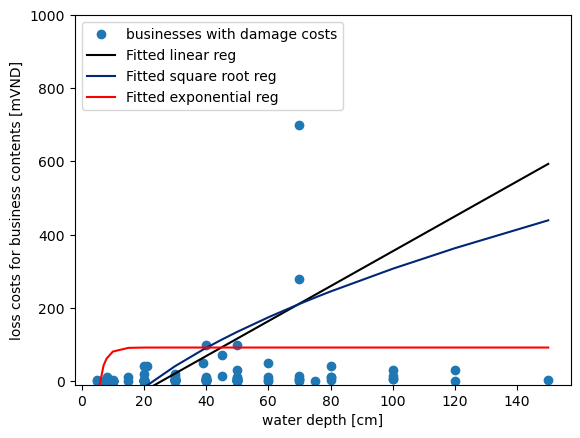

In [10]:
plt.plot(X, y, 'o', label='businesses with damage costs')
plt.plot(X, linear_func(X, *params), 'black', label='Fitted linear reg')
plt.plot(X, root_func(X, *params_root), '#002776', label='Fitted square root reg')
plt.plot(X, exp_func(X, *params_exp), 'r', label='Fitted exponential reg')
#plt.plot(x_fitted, y_fitted, 'r', label='Fitted exponential reg')

plt.ylim(-10,1000)
plt.xlabel("water depth [cm]")
plt.ylabel("loss costs for business contents [mVND]")
plt.legend()

# plt.plot(X.water_depth_cm, y, 'o', label='original data')
# # linear fnc
# plt.plot(X.water_depth_cm, linear_reg.intercept + linear_reg.slope * X.water_depth_cm, 'r', label='fitted linear reg')
#plt.plot(X.water_depth_cm, linear_func(X.water_depth_cm, *params), 'r-')
#         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

## Linear and Square root inundation duration loss functions

In [11]:
df_candidates = df_candidates.sort_values(by='inundation_duration_h')

y = df_candidates.Target_direct_r.astype("float64")
X = df_candidates['inundation_duration_h'].astype("float64")

In [13]:
params, pcov = optimize.curve_fit(linear_func, X, y)
params_root, pcov_root = optimize.curve_fit(root_func, X, y)
params_exp, pcov_exp = optimize.curve_fit(exp_func, X, y)

#linear_reg = stats.linregress(X, y)
print(f"R-squared, linear reg: {adjusted_r2_score(X, y, linear_func(X, *params)):.2f}")
print(f"R-squared, root reg: {adjusted_r2_score(X, y, root_func(X, *params_root)):.2f}")
print(f"R-squared, exponential reg: {adjusted_r2_score(X, y, exp_func(X, *params_exp)):.2f}")

R-squared, linear reg: 0.01
R-squared, root reg: 0.02
R-squared, exponential reg: 0.01


### Plot inundation duration vs Target

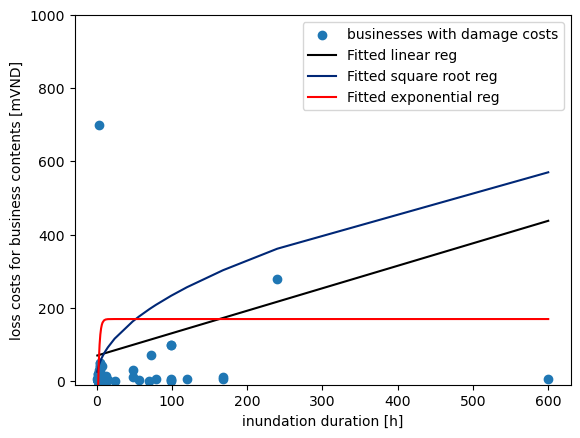

In [15]:
plt.scatter(X, y, label='businesses with damage costs')
#plt.plot(X, y, 'o', label='businesses with damage costs')
plt.plot(X, linear_func(X, *params), 'black', label='Fitted linear reg')
plt.plot(X, root_func(X, *params_root), '#002776', label='Fitted square root reg')
plt.plot(X, exp_func(X, *params_exp) ,'r', label='Fitted exponential reg')

plt.ylim(-10,1000)
plt.xlabel("inundation duration [h]")
plt.ylabel("loss costs for business contents [mVND]")
plt.legend()


## bivariate regressions (linear, square root, expo)


In [16]:
df_candidates = df_candidates.sort_values(by=['water_depth_cm','inundation_duration_h'])

X = df_candidates[['water_depth_cm', 'inundation_duration_h']].values
y = df_candidates['Target_direct_s'].values

In [37]:
def linear_func(x,a,b,c):
    return a*x[0] + b*x[1] + c
# Alternative:
    # linReg = LinearRegression()
    # linReg.fit(x, y)
    # y_pred = linReg.predict(x)
        
def root_func(x,a,b,c):
    return a*np.sqrt(x[0]) + b*np.sqrt(x[1]) + c


def exp_func(x,a,b,d):
    d = 0.5 # initally guessed,  # p_1st[0] 
    return a*np.exp(d*x[0]) + b*np.exp(d*x[1]) # + c  # TODO why decreases r2 if y-intercept is added?

# p = np.polyfit(X, np.log(y), 1) # Fit linear function - polynomial=1
# m = np.exp(p[1]) # Convert the polynomial back into an exponential
# b = p[0]
# x_fitted = np.linspace(np.min(X), np.max(X), 100) # Create the fitted curve
# y_fitted = m * np.exp(b * x_fitted)  # Create the fitted curve



## Bivariate linear and square root functions

Code snippets_ https://enjoymachinelearning.com/blog/multivariate-polynomial-regression-python/

In [38]:
## Fit bivariate regression functions

XX = X.reshape( X.shape[1], X.shape[0])  

params, pcov = optimize.curve_fit(linear_func, XX,  list(y))
params_root, pcov_root = optimize.curve_fit(root_func, XX,  list(y))
params_exp, pcov_exp = optimize.curve_fit(exp_func, XX,  list(y))
print(f"optimized params for exponential func: slope: {params_exp[0]}, b: {params_exp[1]}, intercept={params_exp[2]}")#, intercept{params_exp[2]}")

#linear_reg = stats.linregress(X, y)
print(f"R-squared, linear reg: {adjusted_r2_score(XX, y, linear_func(XX, *params)):.2f}")
#print(f"R-squared, linear reg: {model.score(X, y):.3f}")
print(f"R-squared, root reg: {adjusted_r2_score(XX, y, root_func(XX, *params_root)):.2f}")
print(f"R-squared, exponential reg: {adjusted_r2_score(XX, y, exp_func(XX, *params_exp)):.2f}")


optimized params for exponential func: slope: 5.148200527098145e-130, b: 7.667648073721999e-53, intercept=1.0
R-squared, linear reg: 88.81
R-squared, root reg: 89.29
R-squared, exponential reg: 93.03


c:\Anaconda\envs\py396_c3\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


## Summary

- with two sepeate Targets the bivariate functions perform much better than univarite regressions [R2 between 88-93%]
  - i.e. water depth and indundation duration explain already arounf 90% of the variance in direct loss costs for business contents 
- check if with combined Targets the univarite regressions are still as bad as with two seperate targets

####################################

### reste
- plot MSE
- get acc for each degree, -  example uses polynomials

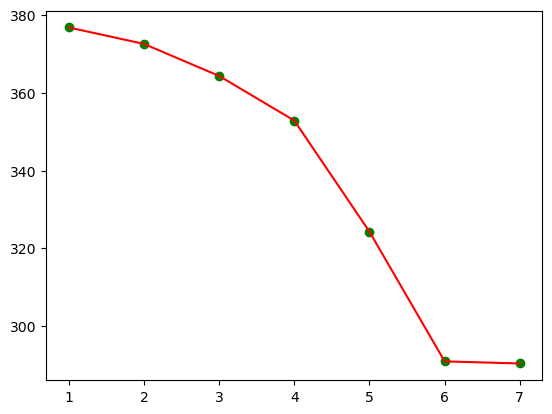

In [147]:
# # check  accuracy for each degree, the lower the error the better!
# number_degrees = [1,2,3,4,5,6,7]
# plt_mean_squared_error = []

# X = df_candidates[['water_depth_cm', 'inundation_duration_h']].values#, # univariate: best with 4 polynomial

# for degree in number_degrees:

#    poly_model = PolynomialFeatures(degree=degree)
  
#    poly_x_values = poly_model.fit_transform(X)
#    poly_model.fit(poly_x_values, y)
  
#    regression_model = LinearRegression()
#    regression_model.fit(poly_x_values, y)
#    y_pred = regression_model.predict(poly_x_values)
  
#    plt_mean_squared_error.append(mean_squared_error(y, y_pred, squared=False))
  
# plt.scatter(number_degrees, plt_mean_squared_error, color="green")
# plt.plot(number_degrees, plt_mean_squared_error, color="red") 